In [10]:
import evolution_system
import numpy as np
import pickle
import os

import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import matplotlib
import matplotlib.colors as mcolors
import seaborn as sns

In [11]:
with open("data/single_run.pickle", "rb") as f:
    x = pickle.load(f)
    verification_system_1 = x['system']
    census = x['census']

In [12]:
p_vals = [1*(x['dip_p'] < 0.1) for x in census]

# check if the number of p-values is at least 1500
max_len = 0; cur_len = 0
for num in p_vals:
    if num == 1:
        cur_len += 1
    else:
        max_len = max(max_len, cur_len)
        cur_len = 0
max_streak= max(max_len, cur_len)

# now we look for the first occurance of speciation (at least 15 consecutive decades
# where the p-value is < 0.05) Convolve over the p_vals with an array of 15 ones,
# look for the sum to be 15 (this indicates consecutive decades of speciation)
convolution = np.convolve(p_vals, np.ones(150), mode='valid') == 150
if convolution.any(): # check if there's a place where we achieve the 15
    index_of_spec = np.argmax(convolution)
else: # otherwise return -1 as an indicator there's no speciation
    index_of_spec = -1

# if there is no speciation event - record speciation generation at nan
if index_of_spec == -1:
    speciation_ybp = np.nan
else: # If there is - check if the index is zero (meaning speciation started immediately)
    if index_of_spec == 0:
        speciation_ybp = 30000
    else: # assuming the speciation exists - look into the "starts" list to record where it begins
        speciation_ybp = 30000 - 10*(index_of_spec + 1)

In [13]:
speciation_ybp

17250

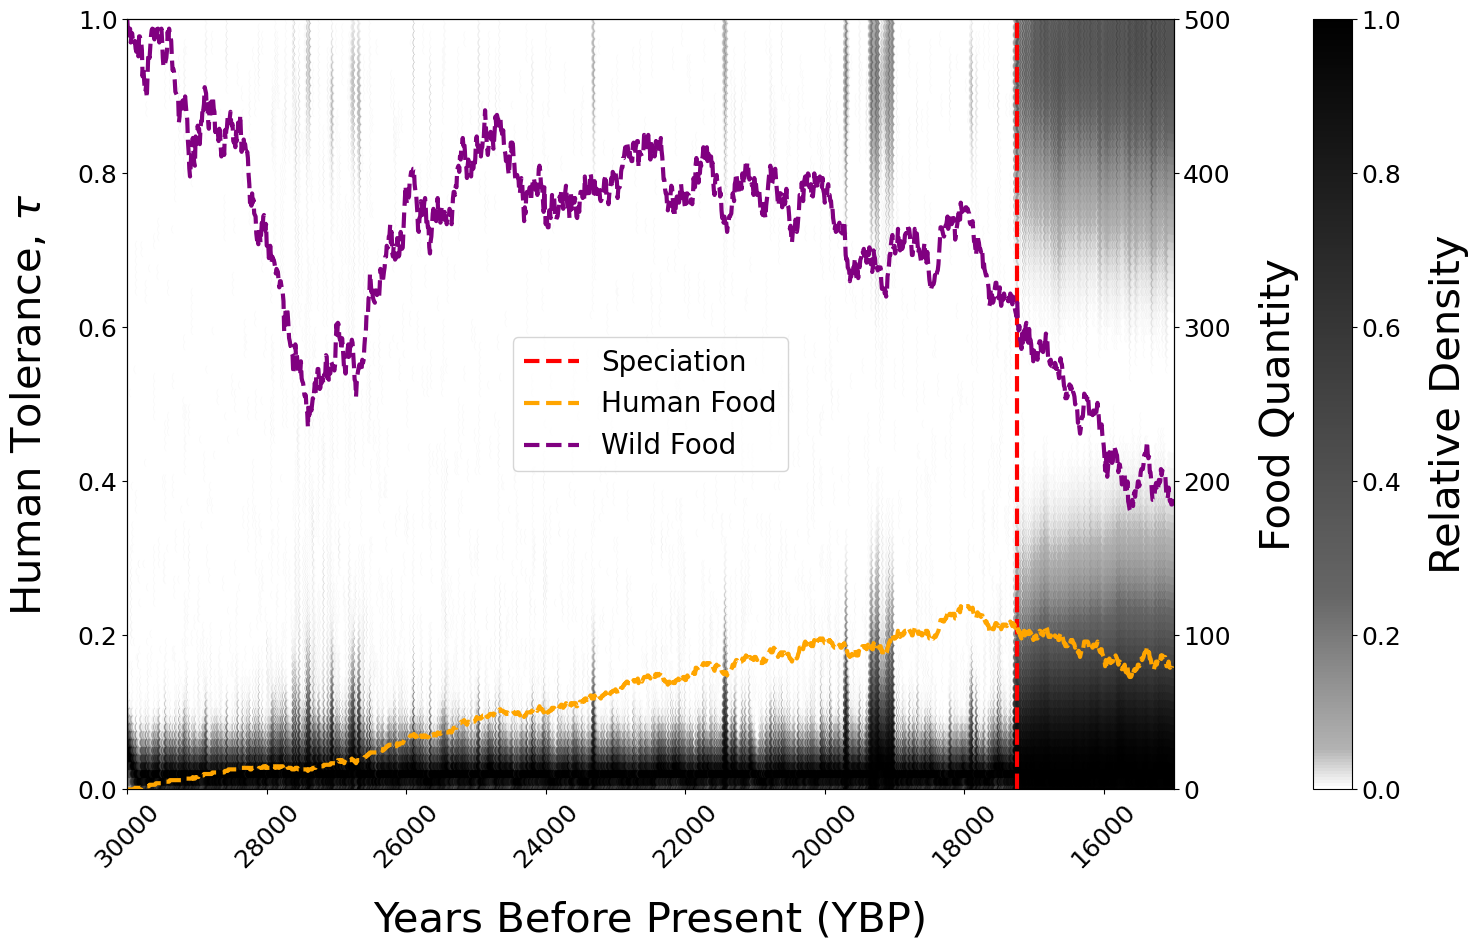

In [23]:
with open("data/single_run.pickle", "rb") as f:
    x = pickle.load(f)
    verification_system_1 = x['system']
    census = x['census']

fig, ax = plt.subplots(figsize = (18, 10))

# Define a list of colors and their positions
colors = [(1, 1, 1), (0.7, 0.7, 0.7), (0.4, 0.4, 0.4), (0, 0, 0)]
positions = [0, 0.05, 0.25, 1]

# Create a colormap with modified values
newcmap = mcolors.LinearSegmentedColormap.from_list('customized', list(zip(positions, colors)))
legend_flag=True
for data in census:
    year = data["YBP"]
    tau_values = data["taus"]
    kde = gaussian_kde(tau_values)
    x_vals = np.linspace(0, 1, num=100)
    y_vals = kde(x_vals)
    y_vals_norm = (y_vals - np.min(y_vals)) / (np.max(y_vals) - np.min(y_vals))
    if year % 10 == 0: 
        sc = ax.scatter([year] * len(x_vals), x_vals, c=y_vals_norm, cmap=newcmap, linewidth=2)

cbar = plt.colorbar(sc, ax=ax, pad=0.1)
cbar.set_label('Relative Density', fontsize=30, labelpad=20)
cbar.ax.tick_params(labelsize=18)


ax.set_ylim(0, 1)

ax.set_xlim(30000, 15000)
plt.vlines(x = speciation_ybp, ymin = 0, ymax = 1, color = 'red', linewidth = 3, linestyle = 'dashed', label = 'Speciation')

ax2 = ax.twinx()
ax2.plot([data["YBP"] for data in census], [data["human_food"] for data in census], linewidth = 3, label = 'Human Food', color='orange', linestyle='dashed')
ax2.plot([data["YBP"] for data in census], [data["wild_food"] for data in census], linewidth = 3, label = 'Wild Food', color='purple', linestyle='dashed')
ax2.set_ylim(0, x['system'].parms['c'])

handles1, labels1 = ax.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
handles = handles1 + handles2
labels = labels1 + labels2
ax.legend(handles, labels, fontsize=20, loc = "center")
ax.tick_params(axis='x', labelrotation = 45)
ax.tick_params(axis='both', labelsize=18)
ax2.tick_params(axis='both', labelsize=18)

ax.set_ylabel("Human Tolerance, " +  r"$\tau$", fontsize=30, labelpad=20)
ax2.set_ylabel("Food Quantity", fontsize=30, labelpad=20)
ax.set_xlabel("Years Before Present (YBP)", fontsize=30, labelpad=20)
fig.savefig('figures/single_run_time_series.png', dpi = 300)

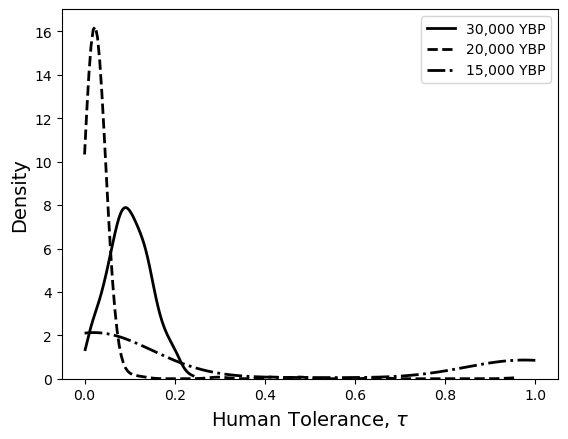

In [22]:
fig, ax = plt.subplots()
years = [0, 1000, 1499]
years_labels = ['30,000 YBP', '20,000 YBP', '15,000 YBP']
line_styles = ['solid', 'dashed', 'dashdot', 'dotted']
for year, lab, ls  in zip(years, years_labels, line_styles):
    tau_values = census[year]['taus']
    sns.kdeplot(tau_values, ax = ax, label = lab, cut = 0, clip = (0,1), linestyle = ls, linewidth = 2, color = 'black')

ax.set_xlabel('Human Tolerance, ' + r'$\tau$', fontsize=14)
ax.set_ylabel('Density', fontsize=14)
ax.legend(loc='best', fontsize=10)
fig.savefig('figures/single_run_distributions.png', dpi = 800)